In [1]:
import pandas as pd
import numpy as np
import eda
import visualization as viz
import feature_engineering as fe
import process_data as pr
import modeling as md

from sklearn.model_selection import StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt
import seaborn as sns

model_number = 'catboost_interactive_features'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.sample(3)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
6848,6848,B,184.67,material_5,material_5,8,8,2,12,5,16.890,9.945,16.184,16.757,12.585,20.355,11.286,19.938,19.056,13.410,14.175,16.889,13.180,13.113,643.182,1
6065,6065,B,113.80,material_5,material_5,8,8,10,18,1,16.731,11.832,18.252,20.365,12.029,20.383,12.849,17.136,20.168,NaN,17.888,15.510,13.166,20.197,790.556,0
8581,8581,B,193.42,material_5,material_5,8,8,8,20,7,17.492,13.993,17.573,17.556,11.169,20.069,13.138,14.115,19.453,11.007,16.540,NaN,17.482,16.921,808.850,0


In [3]:
# Drop the id columns
dropped_columns = ['id', 'product_code']

df_train_model = df_train.drop(dropped_columns, axis=1)
df_test_model = df_test.drop(dropped_columns, axis=1)

# Assign train and test for X and y
X_train = df_train_model.drop('failure', axis=1)
y_train = df_train_model['failure']

X_test = df_test_model.copy()

In [4]:
cat_features = ['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']
continous_features = [cat for cat in X_train.columns if cat not in cat_features]
numerical_features = X_train.select_dtypes(include=['int', 'float']).columns

In [5]:
si = SimpleImputer(strategy='mean')
# Apply preprocessing to the training data
X_train_transformed = si.fit_transform(X_train[continous_features])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train[continous_features].columns)
X_train = pd.concat([X_train[cat_features], X_train_transformed], axis=1)

X_test_transformed = si.transform(X_test[continous_features])
X_test_transformed = pd.DataFrame(X_test_transformed, columns=X_test[continous_features].columns)
X_test = pd.concat([X_test[cat_features], X_test_transformed], axis=1)

X_train.head()

,attribute_0,attribute_1,attribute_2,attribute_3,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,material_7,material_8,9,5,80.10,7.0,8.0,4.0,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594000,15.193,15.029,16.048444,13.034,14.684,764.100
1,material_7,material_8,9,5,84.89,14.0,3.0,3.0,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915000,11.755,14.732,15.425000,14.395,15.631,682.057
2,material_7,material_8,9,5,82.43,12.0,1.0,5.0,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,19.172085,13.798,16.711,18.631000,14.094,17.946,663.376
3,material_7,material_8,9,5,101.07,13.0,2.0,6.0,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377000,10.020,15.250,15.562000,16.154,17.172,826.282
4,material_7,material_8,9,5,188.06,9.0,2.0,8.0,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932000,12.428,16.182,12.760000,13.153,16.412,579.885


In [6]:
target = 'failure'

combined_df = pd.concat([X_train, X_test])
combined_df.sample(2)

,attribute_0,attribute_1,attribute_2,attribute_3,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
6514,material_5,material_6,9,7,102.63,7.0,3.0,9.0,17.068,10.316,16.980,19.320,10.900,19.147,10.064,15.782,19.851,11.833,15.283,15.385,15.431000,14.190,690.691
3464,material_5,material_6,6,4,183.96,3.0,7.0,8.0,18.486,13.265,17.685,17.256,13.166,20.432,11.737,16.466,17.437,12.170,15.936,15.885,14.995554,16.443,971.295


In [7]:
X_train, X_train_interactive, combined_df_train = fe.generate_interactive_features(X_train, X_train[numerical_features])
X_test, X_test_interactive, combined_df_test = fe.generate_interactive_features(X_test, X_test[numerical_features])

c:\Users\Adeniyi Babalola\Documents\GitHub\kaggle\kaggle_competition\data_science_kaggle_coursework\feature_engineering.py:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_interactive[new_feature_name] = df[features[i]] * df[features[j]]
c:\Users\Adeniyi Babalola\Documents\GitHub\kaggle\kaggle_competition\data_science_kaggle_coursework\feature_engineering.py:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_interactive[new_feature_name] = df[features[i]] * df[features[j]]
c:\Users\Adeniyi Babalola\Documents\GitHub\kaggl

In [8]:
X_test_interactive.sample(5)

,attribute_2_attribute_3,attribute_2_loading,attribute_2_measurement_0,attribute_2_measurement_1,attribute_2_measurement_2,attribute_2_measurement_3,attribute_2_measurement_4,attribute_2_measurement_5,attribute_2_measurement_6,attribute_2_measurement_7,attribute_2_measurement_8,attribute_2_measurement_9,attribute_2_measurement_10,attribute_2_measurement_11,attribute_2_measurement_12,attribute_2_measurement_13,attribute_2_measurement_14,attribute_2_measurement_15,attribute_2_measurement_16,attribute_2_measurement_17,attribute_3_loading,attribute_3_measurement_0,attribute_3_measurement_1,attribute_3_measurement_2,attribute_3_measurement_3,attribute_3_measurement_4,attribute_3_measurement_5,attribute_3_measurement_6,attribute_3_measurement_7,attribute_3_measurement_8,attribute_3_measurement_9,attribute_3_measurement_10,attribute_3_measurement_11,attribute_3_measurement_12,attribute_3_measurement_13,attribute_3_measurement_14,attribute_3_measurement_15,attribute_3_measurement_16,attribute_3_measurement_17,loading_measurement_0,loading_measurement_1,loading_measurement_2,loading_measurement_3,loading_measurement_4,loading_measurement_5,loading_measurement_6,loading_measurement_7,loading_measurement_8,loading_measurement_9,loading_measurement_10,loading_measurement_11,loading_measurement_12,loading_measurement_13,loading_measurement_14,loading_measurement_15,loading_measurement_16,loading_measurement_17,measurement_0_measurement_1,measurement_0_measurement_2,measurement_0_measurement_3,measurement_0_measurement_4,measurement_0_measurement_5,measurement_0_measurement_6,measurement_0_measurement_7,measurement_0_measurement_8,measurement_0_measurement_9,measurement_0_measurement_10,measurement_0_measurement_11,measurement_0_measurement_12,measurement_0_measurement_13,measurement_0_measurement_14,measurement_0_measurement_15,measurement_0_measurement_16,measurement_0_measurement_17,measurement_1_measurement_2,measurement_1_measurement_3,measurement_1_measurement_4,measurement_1_measurement_5,measurement_1_measurement_6,measurement_1_measurement_7,measurement_1_measurement_8,measurement_1_measurement_9,measurement_1_measurement_10,measurement_1_measurement_11,measurement_1_measurement_12,measurement_1_measurement_13,measurement_1_measurement_14,measurement_1_measurement_15,measurement_1_measurement_16,measurement_1_measurement_17,measurement_2_measurement_3,measurement_2_measurement_4,measurement_2_measurement_5,measurement_2_measurement_6,measurement_2_measurement_7,measurement_2_measurement_8,measurement_2_measurement_9,measurement_2_measurement_10,measurement_2_measurement_11,measurement_2_measurement_12,measurement_2_measurement_13,measurement_2_measurement_14,measurement_2_measurement_15,measurement_2_measurement_16,measurement_2_measurement_17,measurement_3_measurement_4,measurement_3_measurement_5,measurement_3_measurement_6,measurement_3_measurement_7,measurement_3_measurement_8,measurement_3_measurement_9,measurement_3_measurement_10,measurement_3_measurement_11,measurement_3_measurement_12,measurement_3_measurement_13,measurement_3_measurement_14,measurement_3_measurement_15,measurement_3_measurement_16,measurement_3_measurement_17,measurement_4_measurement_5,measurement_4_measurement_6,measurement_4_measurement_7,measurement_4_measurement_8,measurement_4_measurement_9,measurement_4_measurement_10,measurement_4_measurement_11,measurement_4_measurement_12,measurement_4_measurement_13,measurement_4_measurement_14,measurement_4_measurement_15,measurement_4_measurement_16,measurement_4_measurement_17,measurement_5_measurement_6,measurement_5_measurement_7,measurement_5_measurement_8,measurement_5_measurement_9,measurement_5_measurement_10,measurement_5_measurement_11,measurement_5_measurement_12,measurement_5_measurement_13,measurement_5_measurement_14,measurement_5_measurement_15,measurement_5_measurement_16,measurement_5_measurement_17,measurement_6_measurement_7,measurement_6_measurement_8,measurement_6_measurement_9,measurement

In [9]:
X_train_interactive.shape

(26570, 210)

Learning rate set to 0.067421
0:	learn: 0.6672475	test: 0.6674151	best: 0.6674151 (0)	total: 202ms	remaining: 3m 21s
100:	learn: 0.4857643	test: 0.5108716	best: 0.5105989 (41)	total: 7.13s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5105989134
bestIteration = 41

Shrink model to first 42 iterations.
Learning rate set to 0.067421
0:	learn: 0.6674009	test: 0.6675828	best: 0.6675828 (0)	total: 71.1ms	remaining: 1m 11s
100:	learn: 0.4851975	test: 0.5100704	best: 0.5099902 (92)	total: 8.55s	remaining: 1m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5099902127
bestIteration = 92

Shrink model to first 93 iterations.
Learning rate set to 0.067421
0:	learn: 0.6672356	test: 0.6675502	best: 0.6675502 (0)	total: 104ms	remaining: 1m 43s
100:	learn: 0.4847942	test: 0.5111412	best: 0.5108286 (72)	total: 9.27s	remaining: 1m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.51082863
bestIteration = 72

Shrink 

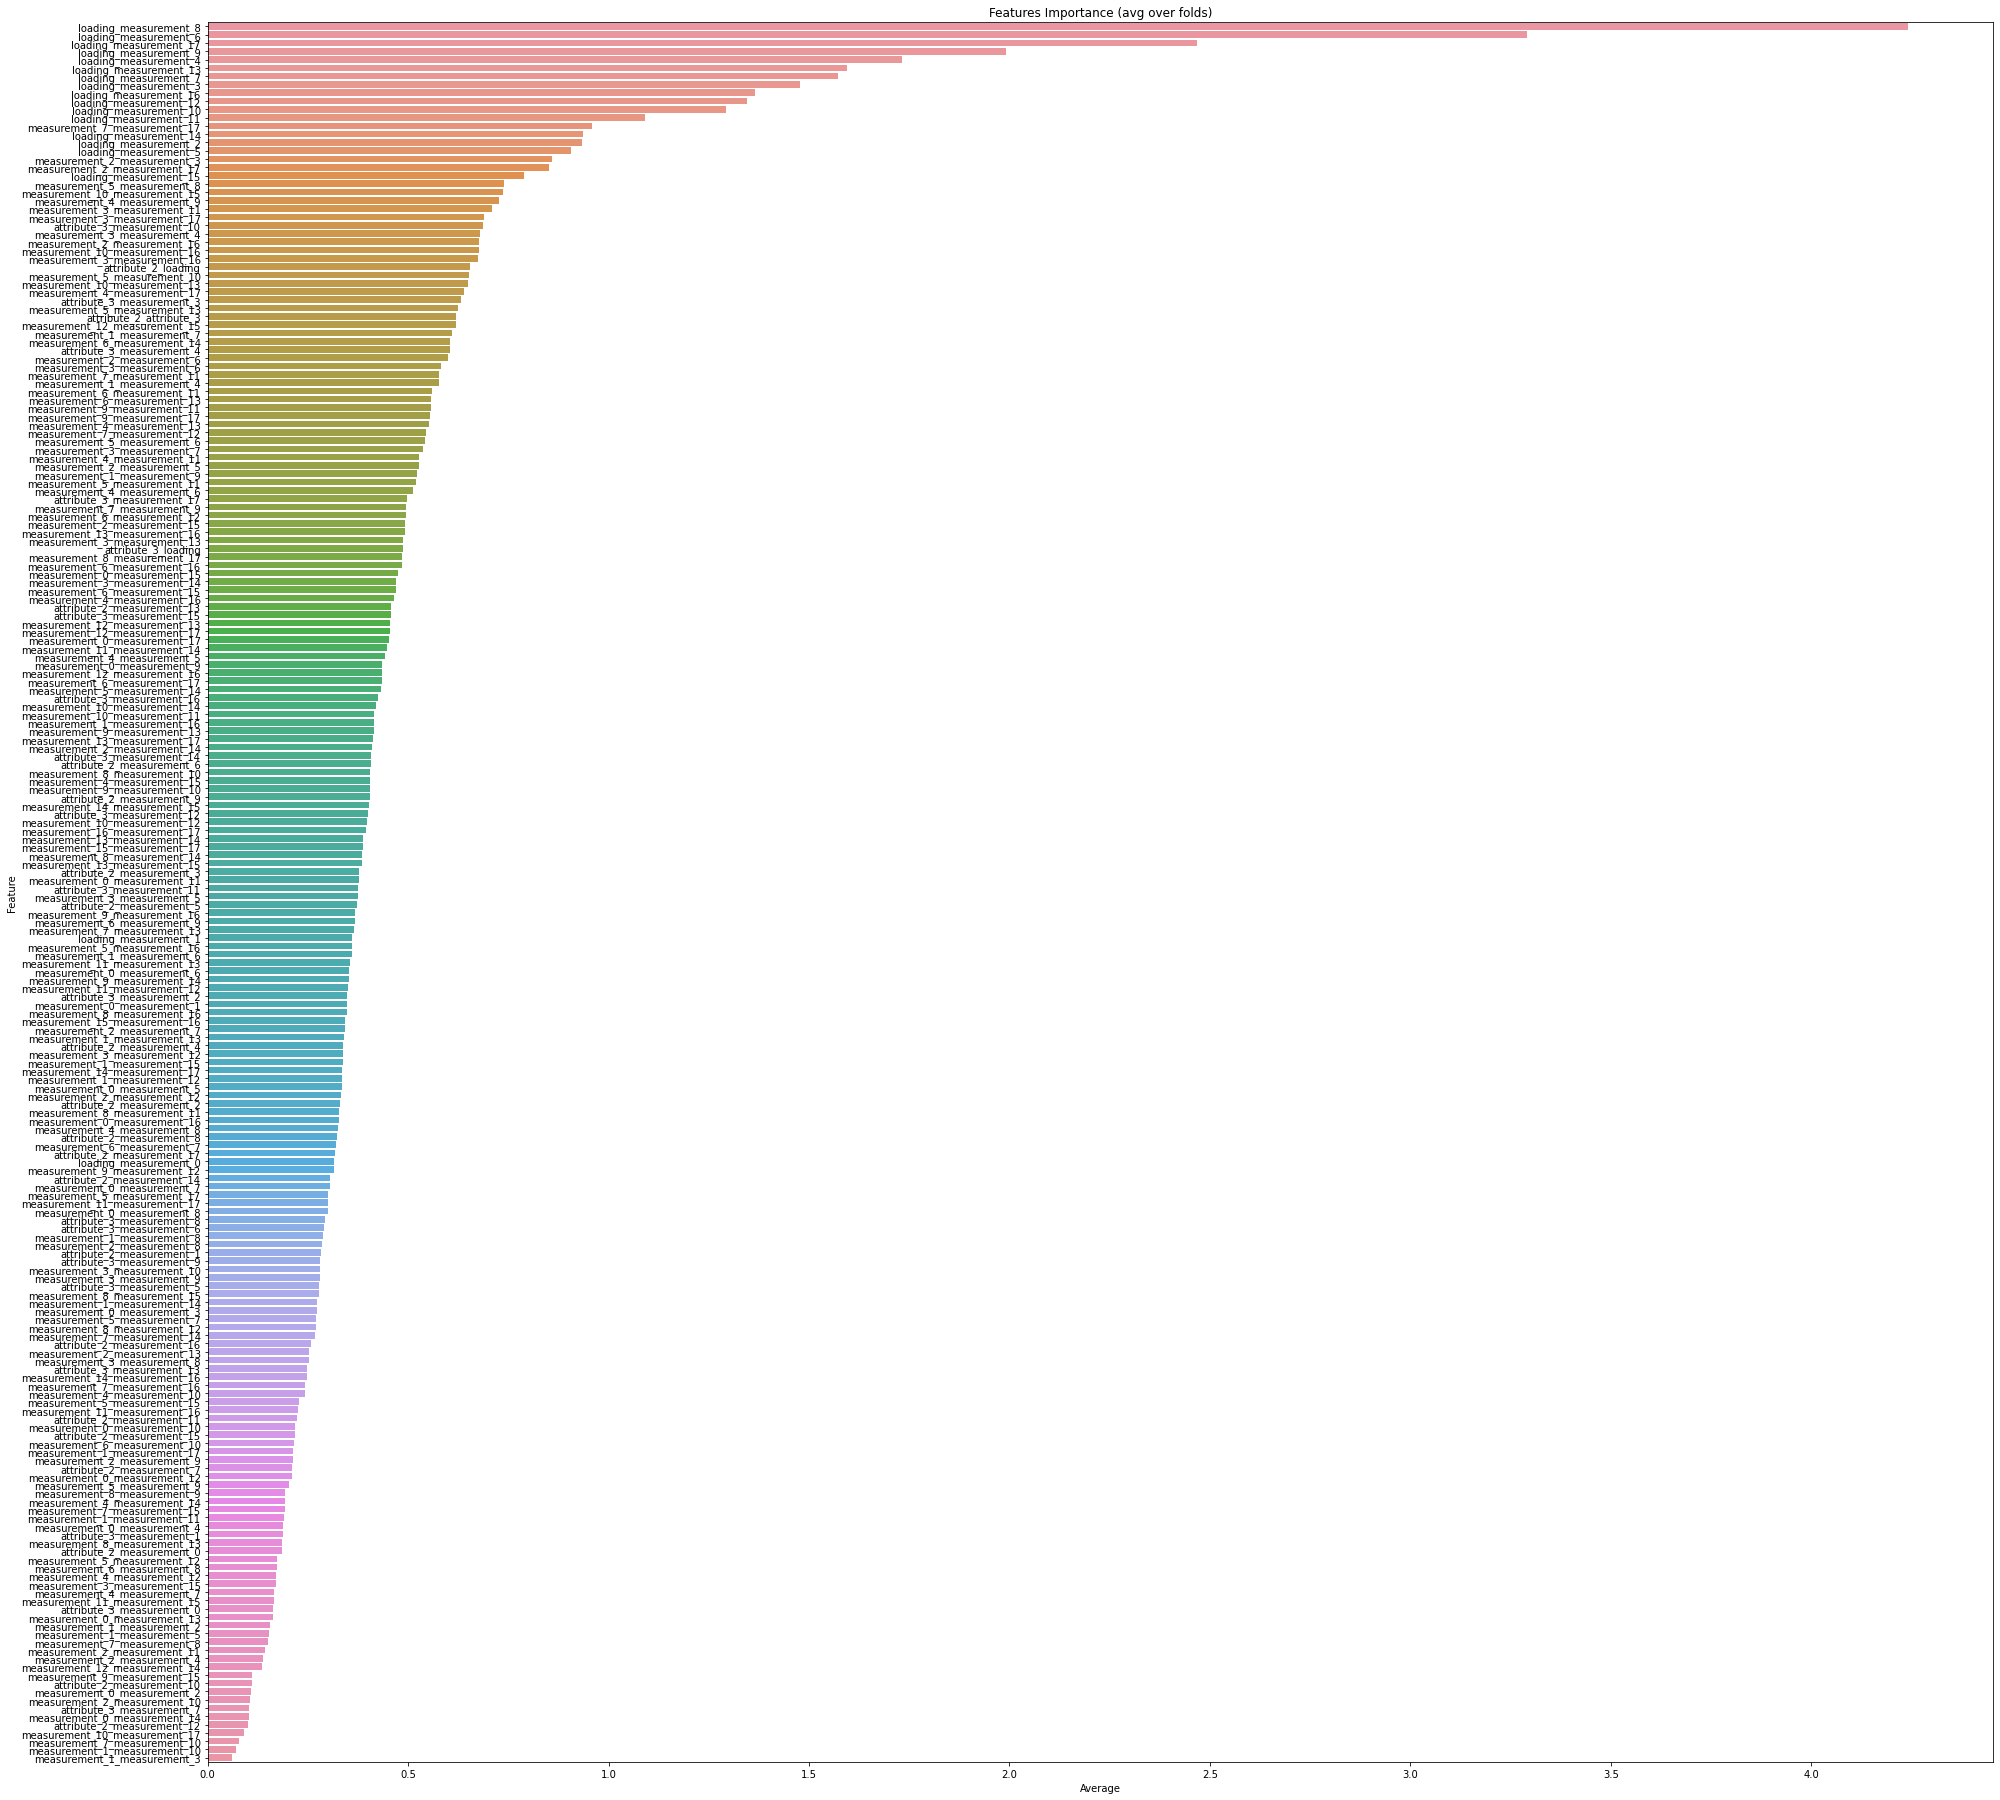

In [10]:
viz.plot_catboost_feature_importance(X_train_interactive, y_train, cat_features=None, figsize=(32, 32))

In [11]:
# Create a blank DataFrame to store the results
result_df = pd.DataFrame({'Feature': X_train_interactive.columns})

In [12]:
# Calculate the mutual information scores 5 times
for i in range(5):
    mi_scores = fe.make_mi_scores_classification(X_train_interactive, y_train)
    result_df[f'Run_{i + 1}'] = mi_scores['MI Score']
    print(result_df.head(5))

                     Feature     Run_1
0    attribute_2_attribute_3  0.000000
1        attribute_2_loading  0.003982
2  attribute_2_measurement_0  0.000000
3  attribute_2_measurement_1  0.000896
4  attribute_2_measurement_2  0.002461
                     Feature     Run_1     Run_2
0    attribute_2_attribute_3  0.000000  0.000000
1        attribute_2_loading  0.003982  0.004342
2  attribute_2_measurement_0  0.000000  0.000000
3  attribute_2_measurement_1  0.000896  0.000000
4  attribute_2_measurement_2  0.002461  0.000000
                     Feature     Run_1     Run_2     Run_3
0    attribute_2_attribute_3  0.000000  0.000000  0.001964
1        attribute_2_loading  0.003982  0.004342  0.004410
2  attribute_2_measurement_0  0.000000  0.000000  0.000000
3  attribute_2_measurement_1  0.000896  0.000000  0.000512
4  attribute_2_measurement_2  0.002461  0.000000  0.000208
                     Feature     Run_1     Run_2     Run_3     Run_4
0    attribute_2_attribute_3  0.000000  0.000000 

In [13]:
result_df['Average'] = result_df.iloc[:, 1:].mean(axis=1)
result_df = result_df.sort_values(by='Average', ascending=False)
result_df.to_csv(f'mi_result{model_number}.csv', index=False)
result_df.head()

,Feature,Run_1,Run_2,Run_3,Run_4,Run_5,Average
47,loading_measurement_8,0.011278,0.011290,0.011331,0.011275,0.011318,0.011298
50,loading_measurement_11,0.010632,0.010665,0.010630,0.010626,0.010659,0.010643
53,loading_measurement_14,0.009788,0.009756,0.009758,0.009797,0.009756,0.009771
42,loading_measurement_3,0.009513,0.009518,0.009457,0.009488,0.009485,0.009492
54,loading_measurement_15,0.009269,0.009313,0.009306,0.009226,0.009534,0.009330


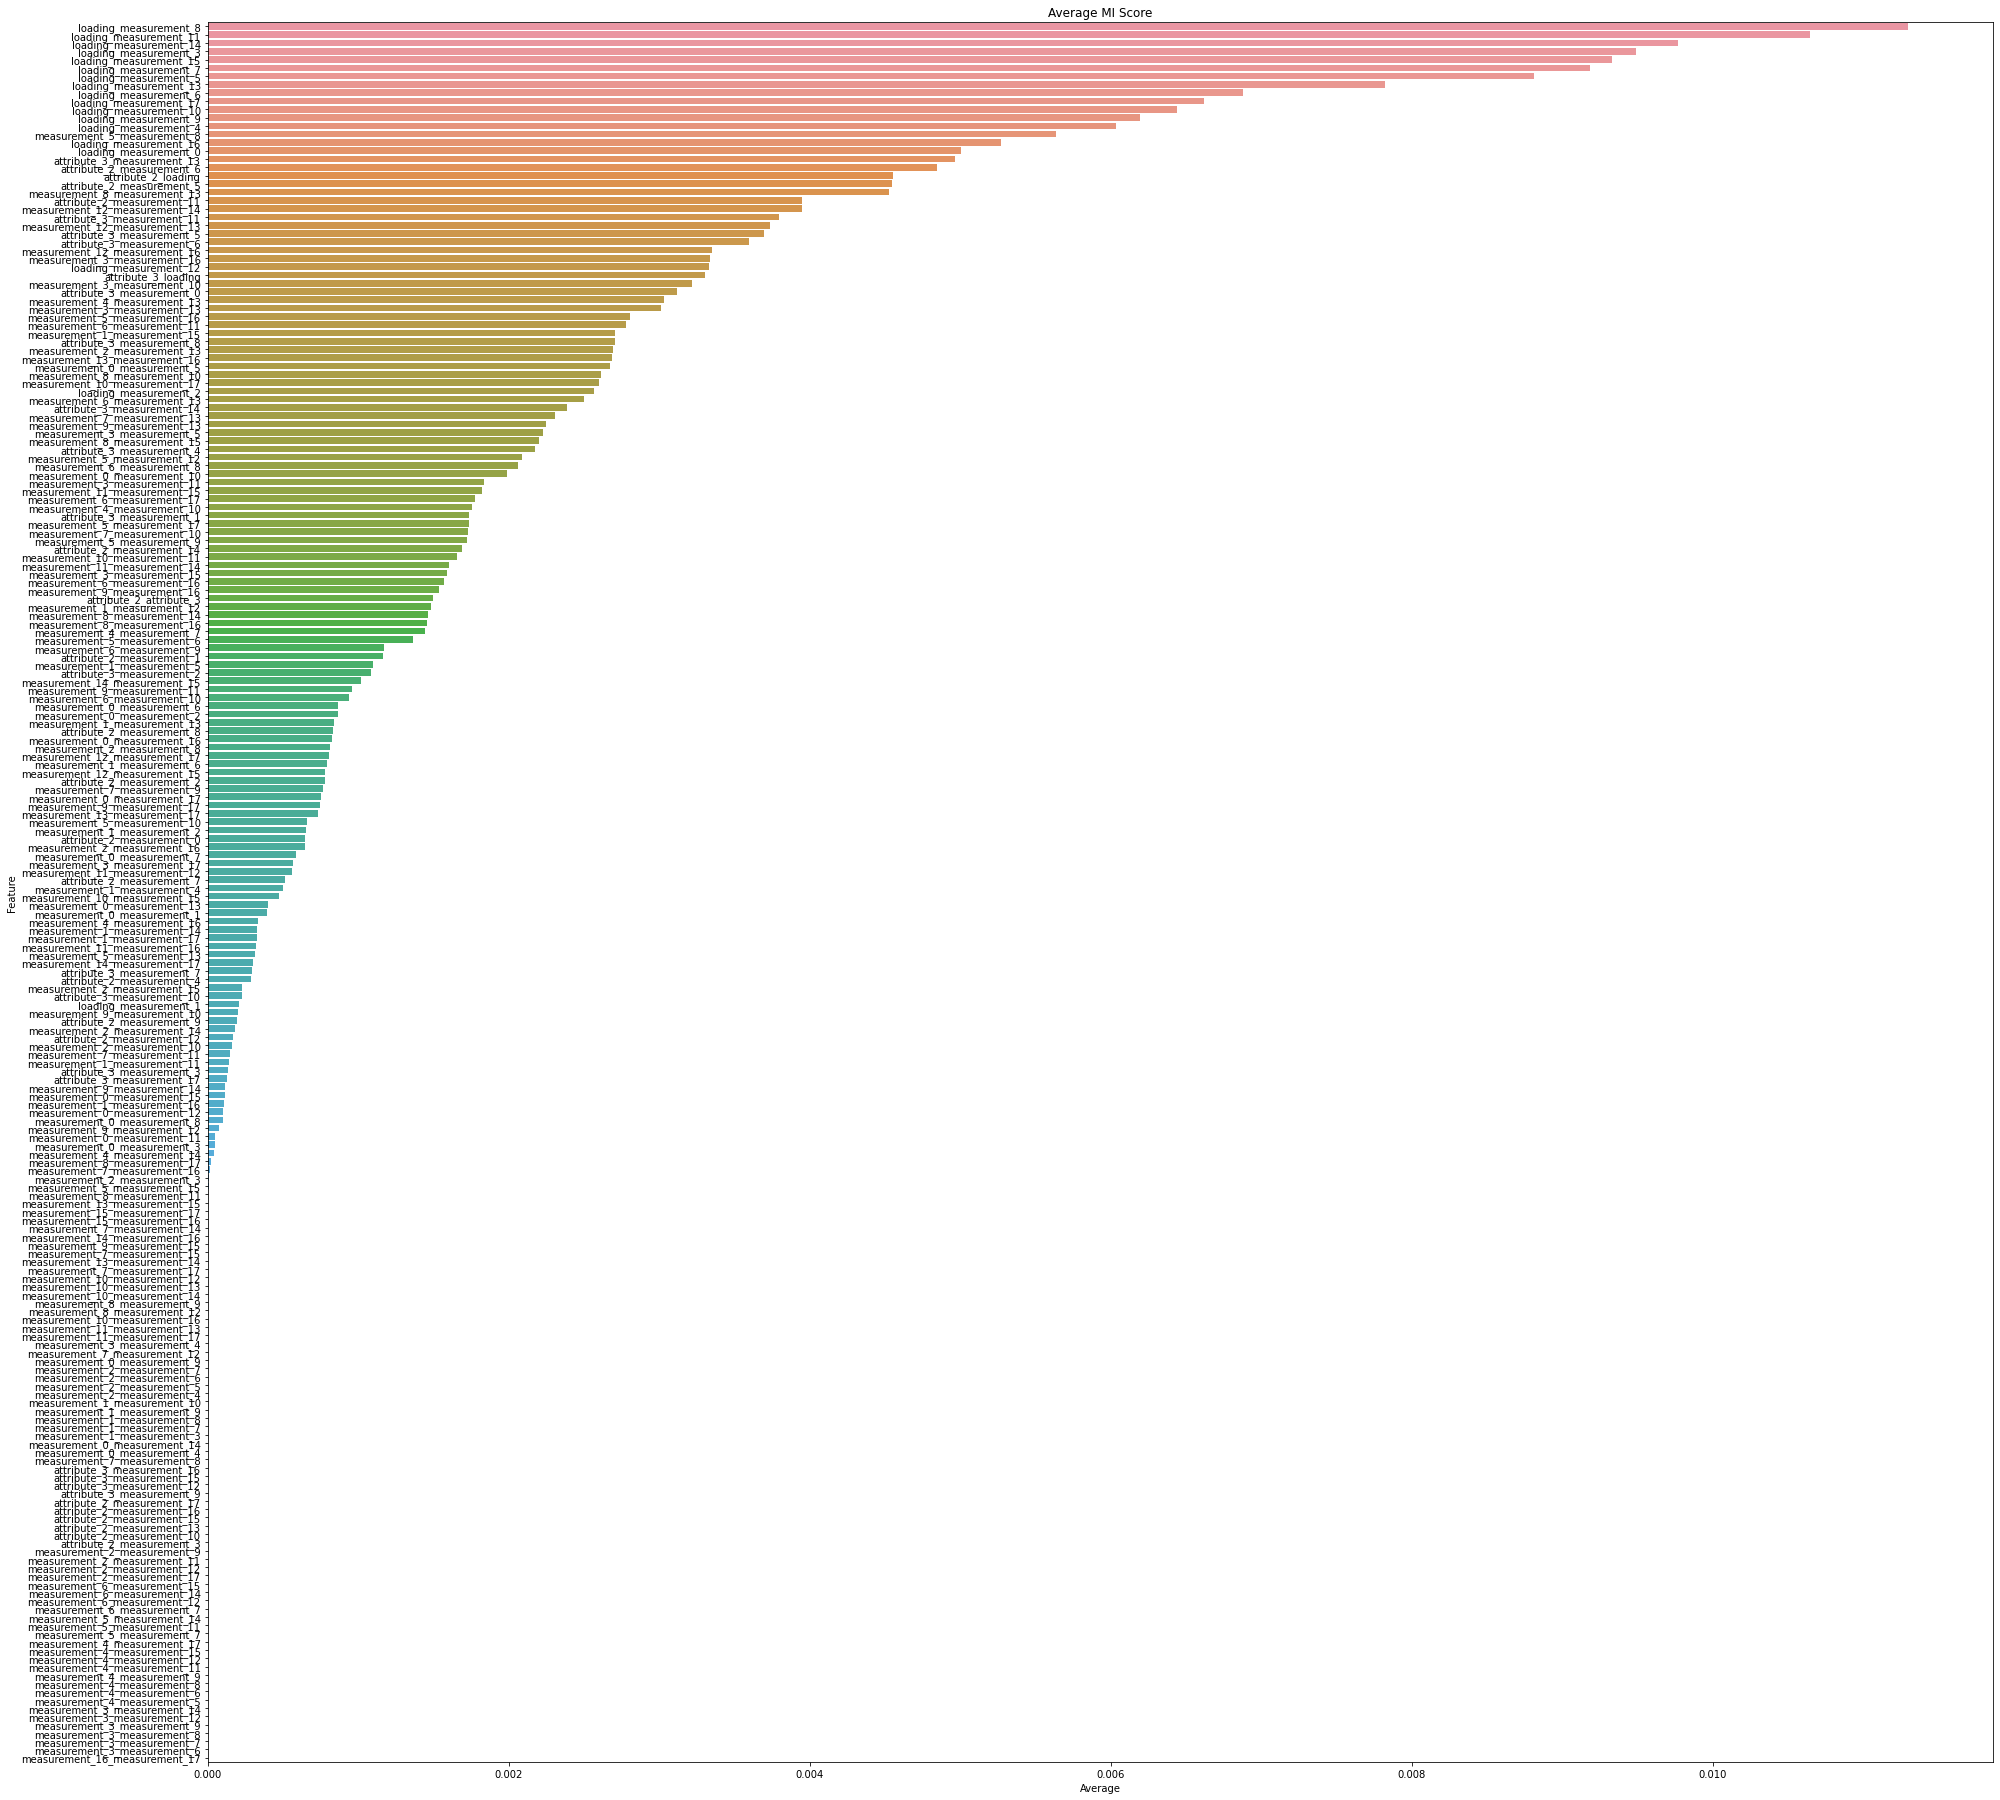

In [14]:
plt.figure(figsize=(32, 32))
sns.barplot(
    x=result_df['Average'],
    y=result_df['Feature'],
)

plt.title('Average MI Score')
plt.show()

In [15]:
fi_df = pd.read_csv('feature_importance.csv')

# Merge the DataFrames on col_a
merged_df = fi_df.merge(result_df, on='Feature')

# Print the merged DataFrame
merged_df = merged_df[['Feature', 'Average_x', 'Average_y']]

merged_df['FI_MI'] = merged_df.iloc[:, 1:].mean(axis=1, skipna=True, numeric_only=True)
merged_df = merged_df.sort_values(by='FI_MI', ascending=False)
merged_df.head(15)

,Feature,Average_x,Average_y,FI_MI
47,loading_measurement_8,4.242198,0.011298,2.126748
45,loading_measurement_6,3.291478,0.006878,1.649178
56,loading_measurement_17,2.468898,0.006618,1.237758
48,loading_measurement_9,1.992109,0.006196,0.999152
43,loading_measurement_4,1.732747,0.006037,0.869392
52,loading_measurement_13,1.595284,0.007822,0.801553
46,loading_measurement_7,1.573212,0.009186,0.791199
42,loading_measurement_3,1.476457,0.009492,0.742974
55,loading_measurement_16,1.365401,0.005272,0.685336
51,loading_measurement_12,1.344097,0.003330,0.673713


In [ ]:
# more_dropped_columns = ['attribute_2', 'measurement_2', 'measurement_7', 'measurement_12', 'measurement_16']
more_dropped_columns = []

# model_number = 'catboost_simpleimputer_domains'

In [16]:
feature_list = merged_df.iloc[:11, :]['Feature'].tolist()
feature_list

['loading_measurement_8',
 'loading_measurement_6',
 'loading_measurement_17',
 'loading_measurement_9',
 'loading_measurement_4',
 'loading_measurement_13',
 'loading_measurement_7',
 'loading_measurement_3',
 'loading_measurement_16',
 'loading_measurement_12',
 'loading_measurement_10']

In [17]:
# Initialize CatBoost model
# model = CatBoostClassifier(random_state=5, cat_features=['attribute_0', 'attribute_1','attribute_2', 'attribute_3'], verbose=False)
model = CatBoostClassifier(random_state=5, verbose=False)

In [18]:
rfecv = RFECV(estimator=model, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

rfecv.fit(X_train_interactive[feature_list], y_train)

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


RFECV(cv=5,
      estimator=<catboost.core.CatBoostClassifier object at 0x000002B7E124CDF0>,
      n_jobs=-1, scoring='roc_auc', verbose=1)

In [19]:
# Get the RFECV ranking of all the features to select which ones to use
# Rank 1 are the features best suited for modelling but rank 2 features aren't bad
# And so on
rfecv_features = pd.DataFrame({'Feature': list(X_test_interactive[feature_list].columns),
                               'Ranking': rfecv.ranking_})

rfecv_features.sort_values(by='Ranking', inplace=True)

rfecv_features

,Feature,Ranking
1,loading_measurement_6,1
3,loading_measurement_9,2
10,loading_measurement_10,3
2,loading_measurement_17,4
9,loading_measurement_12,5
6,loading_measurement_7,6
5,loading_measurement_13,7
8,loading_measurement_16,8
4,loading_measurement_4,9
7,loading_measurement_3,10


In [20]:
# Get the index of Rank 1 features

selected_features = [i for i, selected in enumerate(rfecv.support_) if selected]

In [21]:
# Get a list of the rank 1 features
rfecv_rank_1 = list(X_train_interactive[feature_list].columns[selected_features])
rfecv_rank_1

['loading_measurement_6']

In [22]:
num_folds = 5
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=5)

# scores = cross_val_score(model, X_train.drop(dropped_columns_low_fi, axis=1), y_train, cv=cv, n_jobs=-1, scoring='roc_auc')
# scores = cross_val_score(model, X_train.drop(more_dropped_columns, axis=1), y_train, cv=cv, n_jobs=-1, scoring='roc_auc')
scores = cross_val_score(model, X_train_interactive[rfecv_rank_1], y_train, cv=cv, n_jobs=-1, scoring='roc_auc')

list(scores), scores.mean(), scores.std()

([0.5769699240084107,
  0.586982753515288,
  0.569001907815699,
  0.5763175984365219,
  0.5829693607336841],
 0.5784483089019208,
 0.006152019131742243)

In [24]:
# Fit the model on the entire training data
# model.fit(X_train.drop(dropped_columns_low_fi, axis=1), y_train)
model.fit(X_train_interactive[rfecv_rank_1], y_train)

# Predict on the X_test data
# predictions = model.predict_proba(X_test.drop(dropped_columns_low_fi, axis=1))[:, 1]
predictions = model.predict_proba(X_test_interactive[rfecv_rank_1])[:, 1]

# Create a DataFrame for submission
submission_df = pd.DataFrame(
    {'id': df_test['id'],
    'failure': predictions})

# submission_df.head(50)
# Save to CSV for submission
submission_df.to_csv(f'submission_{model_number}.csv', index=False)